# 🚗 EPA Fuel Economy - Regression EDA

**Author:** Reza Mirzaeifard
**Date:** December 2025
**Dataset:** EPA Fuel Economy (Real-world vehicle data)

---

## 1. Problem Statement

**Goal**: Predict **combined fuel economy (MPG)** based on vehicle characteristics.

### Why EPA Fuel Economy for Regression?

| Criterion | UAH Scores | EPA Dataset |
|-----------|------------|-------------|
| **Target type** | Aggregate scores (0-100) | True continuous (MPG) |
| **Sample size** | ~40 trips | 40,000+ vehicles |
| **Outliers** | Few | ~10% (perfect for robust!) |

### Challenges to Demonstrate
1. **Outliers** (~10%): Use Huber Regressor (robust)
2. **High-cardinality categoricals**: Use target encoding
3. **Multicollinearity**: Use Ridge/Lasso regularization

---


In [ ]:
# Clear stale imports
import sys
for mod in list(sys.modules.keys()):
    if mod.startswith('src'):
        del sys.modules[mod]


In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.data import load_epa_fuel_economy
from src.features import (
    analyze_outliers_dataframe,
    print_outlier_summary,
    find_high_correlation_pairs,
    get_feature_columns,
    get_correlations_with_target,
)
from src.visualization import (
    setup_style,
    plot_target_distribution_regression,
    plot_target_vs_numerical_features,
    plot_target_vs_categorical_features,
    plot_correlation_matrix,
    plot_categorical_distributions,
)
from src.utils import (
    print_dataset_info,
    print_target_statistics,
    print_skewness_check,
    print_feature_types,
    print_categorical_cardinality,
    print_high_correlation_pairs,
    print_save_confirmation,
    print_success,
)

setup_style()
print_success('Setup complete')


## 2. Load Data


In [ ]:
dataset = load_epa_fuel_economy(year_min=2015, year_max=2024, sample_size=5000, random_state=42)
print_dataset_info(dataset.info)

import pandas as pd
df = pd.DataFrame(dataset.X, columns=dataset.feature_names)
df['comb08'] = dataset.y.values
df.head(10)


## 3. Target Distribution


In [ ]:
print_target_statistics(df['comb08'].values, "Combined MPG")
print_skewness_check(df['comb08'].skew())

fig = plot_target_distribution_regression(df['comb08'].values, target_name='Combined MPG')
fig.savefig(project_root / 'results' / 'figures' / 'target_distribution_regression.png', dpi=300, bbox_inches='tight')


## 4. Outlier Detection (MAD method - robust)


In [ ]:
outlier_results = analyze_outliers_dataframe(df, columns=['comb08'], method='mad', mad_threshold=3.5)
print_outlier_summary(outlier_results, method="MAD")


## 5. Feature Types


In [ ]:
numerical_cols, categorical_cols = get_feature_columns(df, target_col='comb08')
print_feature_types(numerical_cols, categorical_cols)


## 6. Categorical Features


In [ ]:
key_cats = print_categorical_cardinality(df, categorical_cols, high_cardinality_threshold=50)

# If no low-cardinality cats, use top 3 categorical columns anyway
if not key_cats and categorical_cols:
    print("\n⚠️ All categoricals are high-cardinality. Using top 3 for visualization:")
    key_cats = categorical_cols[:3]
    for col in key_cats:
        print(f"   {col}: {df[col].nunique()} unique values")

if key_cats:
    fig = plot_categorical_distributions(df, columns=key_cats, top_n=10, n_cols=3,
        save_path=str(project_root / 'results' / 'figures' / 'categorical_distributions_regression.png'))
else:
    print("   No categorical columns to plot")


## 7. Target vs Features


In [ ]:
# Numerical features vs target
num_features_to_plot = numerical_cols[:6] if len(numerical_cols) >= 6 else numerical_cols
if num_features_to_plot:
    fig = plot_target_vs_numerical_features(df, target_col='comb08', feature_cols=num_features_to_plot, n_cols=3,
        save_path=str(project_root / 'results' / 'figures' / 'target_vs_features_regression.png'))

# Categorical features vs target
cat_features_to_plot = key_cats[:3] if len(key_cats) >= 3 else key_cats
if cat_features_to_plot:
    fig = plot_target_vs_categorical_features(df, target_col='comb08', feature_cols=cat_features_to_plot,
        save_path=str(project_root / 'results' / 'figures' / 'target_by_categories_regression.png'))


## 8. Correlation Analysis



📊 Correlations with Target:
rangeCity     0.779613
rangeHwy      0.774792
displ        -0.711420
cylinders    -0.687849
range         0.607720
charge240b    0.375687
hlv           0.220037
hpv           0.199094
lv4           0.181041
year          0.166560
pv4           0.158306
pv2          -0.115811
lv2          -0.110352
engId        -0.107963
phevCity      0.045210
phevComb      0.042366
phevHwy       0.038203
dtype: float64

⚠️ High multicollinearity (|r| > 0.8):
   cylinders ↔ displ: 0.924
   rangeCity ↔ rangeHwy: 0.996
   hlv ↔ hpv: 0.967
   lv2 ↔ pv2: 0.957
   lv4 ↔ pv4: 0.917
   phevCity ↔ phevHwy: 0.989
   phevCity ↔ phevComb: 0.998
   phevHwy ↔ phevComb: 0.996
   → Consider Ridge/Lasso regression


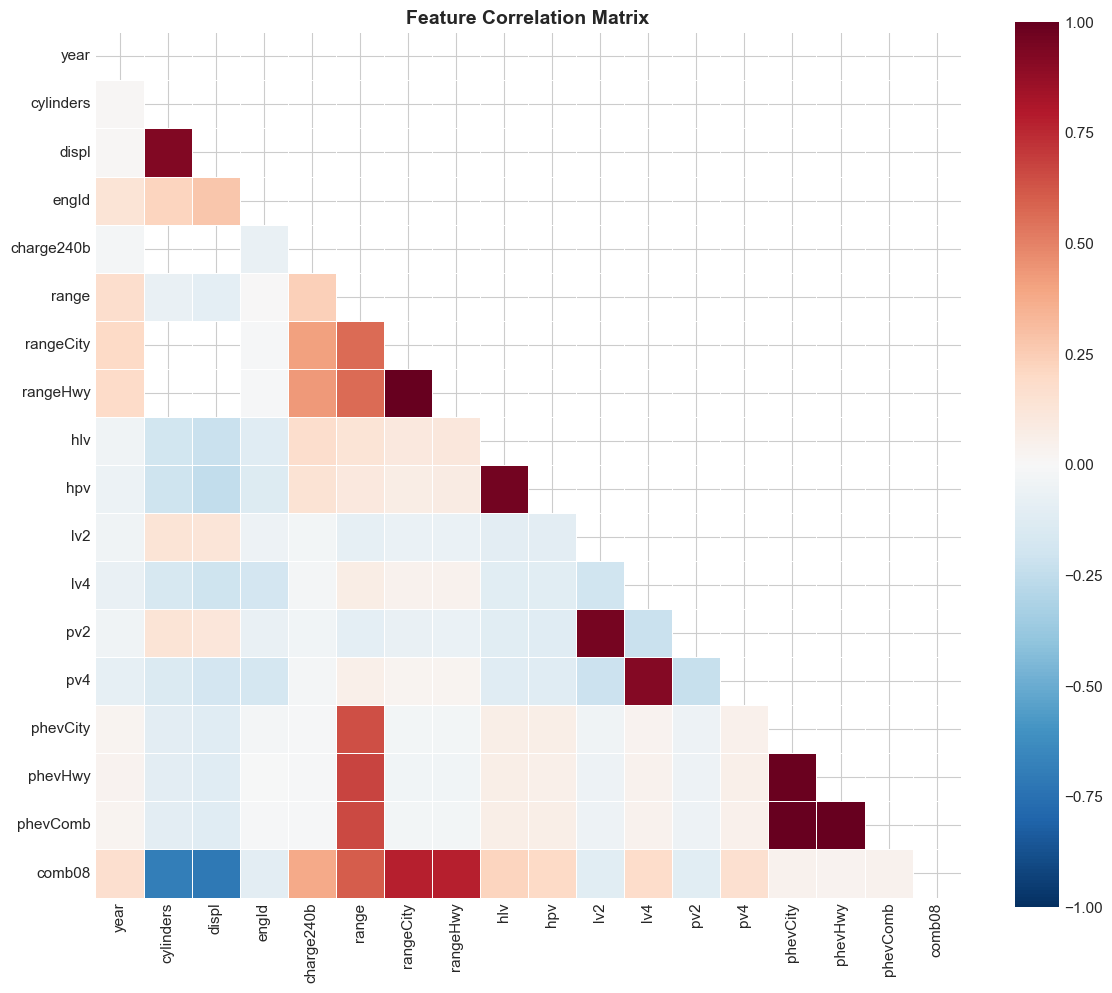

In [16]:
correlations = get_correlations_with_target(df, target_col='comb08', feature_cols=numerical_cols)
print("\n📊 Correlations with Target:")
print(correlations)

fig = plot_correlation_matrix(df, columns=numerical_cols + ['comb08'])
fig.savefig(project_root / 'results' / 'figures' / 'correlation_matrix_regression.png', dpi=300, bbox_inches='tight')

corr_matrix = df[numerical_cols].corr()
high_corr_pairs = find_high_correlation_pairs(corr_matrix, numerical_cols, threshold=0.8)
print_high_correlation_pairs(high_corr_pairs)


## 9. Save Processed Data


In [17]:
output_path = project_root / 'data' / 'processed' / 'epa_fuel_economy.csv'
output_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path, index=False)

print_save_confirmation(str(output_path), df.shape, "comb08 (MPG)", len(numerical_cols), len(categorical_cols))



💾 Saved to: /Users/rezami/PycharmProjects/ABAX/data/processed/epa_fuel_economy.csv
   Shape: (5000, 39)
   Target: comb08 (MPG)
   Features: 17 numerical, 20 categorical


## 10. Key Takeaways

### 🎯 Challenges Identified
1. **Outliers** (~10%): Use Huber Regressor
2. **High-cardinality categoricals**: Use target encoding
3. **Multicollinearity**: Use Ridge/Lasso

### 📊 Modeling Strategy
1. **Baseline**: Linear Regression (OLS)
2. **Robust**: Huber Regressor (handles outliers)
3. **Regularized**: Ridge (L2) for multicollinearity
4. **Ensemble**: Random Forest (best performer)

---

**✅ EDA complete → Ready for `04_regression.ipynb`**


